# Sentiment Analysis on Climate Change Using Twitter Data.
© Explore Data Science Academy

## Honour Code

I **Brendon, Mapinda**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code (https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.


### Introduction 

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

### Evaluation metric

The F1 score, commonly used in information retrieval, measures performance using using the statistics precision and recall.

Precision is the ratio of true positives to all predicted positives. Recall is the ratio of true positives to all actual positives.

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

# Dataset Description

### Where is this data from?
The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43,943 tweets were collected. Each tweet is labelled as one of 4 classes, which are described below.

#### Class Description

2 News: the tweet links to factual news about climate change

1 Pro: the tweet supports the belief of man-made climate change

0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

-1 Anti: the tweet does not believe in man-made climate change Variable definitions

#### Features

sentiment: Which class a tweet belongs in (refer to Class Description above)

message: Tweet body

tweetid: Twitter unique id

The files provided

train.csv - I will use this data to train my model.

test.csv - I will use this data to test my model.

SampleSubmission.csv - is an example of what my submission file should look like. The order of the rows does not matter, but the names of the tweetid's must be correct.

<a id="section-four"></a>
# Import libraries and datasets

In [69]:
# Standard Packages  
import numpy as np
import pandas as pd
from time import time

# Packages for visualisations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set(font_scale=1.5)
import matplotlib.style as style
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image

# Packages for preprocessing
import re
import nltk
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
import emoji
from ftfy import fix_text
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet 
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import itertools
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Packages for training models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

# Packages for hyperparameter optimisation
from sklearn.model_selection import GridSearchCV

# Packages for evaluating model accuracy
from sklearn import metrics
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize

# Packages for saving models
import pickle

[nltk_data] Downloading package omw-1.4 to C:\Users\HP
[nltk_data]     PAVILION\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP PAVILION\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<a id="subsection-two"></a>
# Loading the Datasets

In [70]:
# Import training dataset
df_train = pd.read_csv(r"C:\Users\HP PAVILION\Desktop\Python\ML\New folder (2)\Advanced_Classification_Predict-student_data-2780\train.csv")

# Import testing dataset
df_test = pd.read_csv(r"C:\Users\HP PAVILION\Desktop\Python\ML\New folder (2)\Advanced_Classification_Predict-student_data-2780\test_with_no_labels.csv")

# Set 'tweetid' index
df_train.set_index('tweetid',inplace = True)
df_test.set_index('tweetid',inplace = True)

<a id="subsection-three"></a>
# Reading the Datasets


In [71]:
# A look at the data structure
print(df_train.shape)
print(df_test.shape)

display (df_train.head())
display (df_test.head())

(15819, 2)
(10546, 1)


sentiment                                            message
tweetid                                                              
625221           1  PolySciMajor EPA chief doesn't think carbon di...
126103           1  It's not like we lack evidence of anthropogeni...
698562           2  RT @RawStory: Researchers say we have three ye...
573736           1  #TodayinMaker# WIRED : 2016 was a pivotal year...
466954           1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...

message
tweetid                                                   
169760   Europe will now be looking to China to make su...
35326    Combine this with the polling of staffers re c...
224985   The scary, unimpeachable evidence that climate...
476263   @Karoli @morgfair @OsborneInk @dailykos \nPuti...
872928   RT @FakeWillMoore: 'Female orgasms cause globa...

<a id="section-seven"></a>
# Preprocessing
* Extract tweet sentiments
* Extract hashtags
* Replace contractions
* Remove URLS, emojis,punctuations,mentions, numbers and extra white space
* Convert all text to lowercase
* Replace shortened words/slang
* Tokenization
* Perform lemmatization


In [73]:
# create a copy of the train dataframe
def update(df):
    
    """
    This function creates a copy of the original train data and 
    renames the classes, converting them from numbers to words
    
    Input: 
    df: original dataframe
        datatype: dataframe
    
    Output:
    df: modified dataframe
        datatype: dataframe 
        
    """

    df = df_train.copy()
    sentiment = df['sentiment']
    word_sentiment = []

    for i in sentiment :
        if i == 1 :
            word_sentiment.append('Pro')
        elif i == 0 :
            word_sentiment.append('Neutral')
        elif i == -1 :
            word_sentiment.append('Anti')
        else :
            word_sentiment.append('News')

    df['sentiment'] = word_sentiment
    
    return df

df = update(df_train)
df.head()

sentiment                                            message
tweetid                                                             
625221        Pro  PolySciMajor EPA chief doesn't think carbon di...
126103        Pro  It's not like we lack evidence of anthropogeni...
698562       News  RT @RawStory: Researchers say we have three ye...
573736        Pro  #TodayinMaker# WIRED : 2016 was a pivotal year...
466954        Pro  RT @SoyNovioDeTodas: It's 2016, and a racist, ...

# Extracting Hashtags
Extracting hashtags for original tweets and storing them in seperate dataframes for each class before first cleaning the data.

In [74]:
def hashtag_extract(tweet):
    
    """
    This function takes in a tweet and extracts the top 15 hashtag(s) using regular expressions
    These hashtags are stored in a seperate dataframe 
    along with a count of how frequenty they occur
    
    Input:
    tweet: original tweets
           datatype: 'str'
           
    Output:
    hashtag_df: dataframe containing the top hashtags in the tweets
              datatype: dataframe         
    """
    
    hashtags = []
    
    for i in tweet:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

# Extracting the hashtags from tweets in each class
pro = hashtag_extract(df['message'][df['sentiment'] == 'Pro'])
anti = hashtag_extract(df['message'][df['sentiment'] == 'Anti'])
neutral = hashtag_extract(df['message'][df['sentiment'] == 'Neutral'])
news = hashtag_extract(df['message'][df['sentiment'] == 'News'])

pro.head()

hashtag  count
19          climate    187
24   BeforeTheFlood    129
68    climatechange     94
13  ImVotingBecause     62
4             COP22     59

# Extracting Sentiments of Tweets
classifying all tweets with scores of less than -0.05 as negative, scores between -0.05 and 0.05 are classified as neutral and a score of more than 0.05 indicates a positive tweet.

In [75]:
# extract sentiment
def sentiment_score(text):
    """ A function that determines the sentiment of a text string.

        Parameters
        ----------
        text: Text string.

        Returns
        -------
        sentiment:  String indicating the sentiment of the input string.
    """
    
    sid = SentimentIntensityAnalyzer()
    s = sid.polarity_scores(text)['compound']
    if s<-0.05:
        sentiment='negative'
    elif s>0.05:
        sentiment='positive'
    else:
        sentiment='neutral'
    
    return sentiment

In [76]:
# Extract all unique news related handles into a list
df_temp = df_train.copy()
df_temp.sort_index(inplace=True)
n_temp = [re.findall(r'@[\w]+',df_temp['message'].iloc[i]) for i,x in enumerate(df_temp['sentiment']) if x==2]
news = [x for x in n_temp if x!=[]]

# Only keep the unique values inside the list
news = sorted(list(set(itertools.chain.from_iterable(news))))

In [77]:
# extracting all unique hashtags
hashtags = df['message'].apply(lambda x: re.findall(r'[#]\\w+',x))

In [78]:
hashtags = list(set([item for sublist in hashtags for item in sublist]))


In the next steps, we will be removing URL's, punctuations, mentions, numbers, extra white spaces and normalizing by converting all letters to lowercase

In [79]:
# Dictionary of contracted words
contractions = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"wasn't": "was not",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we'll":"we will",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
}

In [80]:
# Replace contracted words with full words
df_train['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) 
                       for raw in df_train['message']]

In [81]:
# Lower case all words to remove noise from Capital words. Capital words may be seen as different from lower case words
df_train['message'] = df_train['message'].str.lower()

In [82]:
# Fix all the bad unicode to allow better processing of the data
df_train['message'] = df_train['message'].apply(lambda x: fix_text(x))

In [83]:
# Removing urls
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'https\S+','url',x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'www\S+', 'url',x))

In [84]:
# Replace emojis with their word meaning
df_train['message'] = df_train['message'].apply(lambda x: emoji.demojize(x))

In [85]:
# Replace shortened words with full words
short = {' BD ': ' Big Deal ',
 ' abt ':' about ',
 ' ab ': ' about ',
 ' fav ': ' favourite ',
 ' fab ': ' fabulous ',
 ' smh ': ' shaking my head ',
 ' u ': ' you ',
 ' c ': ' see ',
 ' anon ': ' anonymous ',
 ' ac ': ' aircon ',
 ' a/c ': ' aircon ',
 ' yo ':' year old ',
 ' n ':' and ',
 ' nd ':' and ',
 ' 2 ': ' to ',
 ' w ': ' with ',
 ' w/o ': ' without ',
 ' r ': ' are ',
 ' rip ':' rest in peace ',
 ' 4 ' : ' for ',
' BF ': ' Boyfriend ',
' BRB ': ' Be Right Back ',
' BTW ': ' By The Way ',
' GF ': ' Girlfriend ',
' HBD ': ' Happy Birthday ',
' JK ': ' Just Kidding ',
' K ':' Okay ',
' LMK ': ' Let Me Know ',
' LOL ': ' Laugh Out Loud ',
' HA ':' laugh ',
' MYOB ': ' Mind Your Own Business ',
' NBD ': ' No Big Deal ',
' NVM ': ' Nevermind ',
' Obv ':' Obviously ',
' Obvi ':' Obviously ',
' OMG ': ' Oh My God ',
' Pls ': ' Please ',
' Plz ': ' Please ',
' Q ': ' Question ', 
' QQ ': ' Quick Question ',
' RLY ': ' Really ',
' SRLSY ': ' Seriously ',
' TMI ': ' Too Much Information ',
' TY ': ' Thank You, ',
' TYVM ': ' Thank You Very Much ',
' YW ': ' You are Welcome ',
' FOMO ': ' Fear Of Missing Out ',
' FTFY ': ' Fixed This For You ',
' FTW ': ' For The Win ',
' FYA ': ' For Your Amusement ',
' FYE ': ' For Your Entertainment ',
' GTI ': ' Going Through It ',
' HTH ': ' Here to Help ',
' IRL ': ' In Real Life ',
' ICYMI ': ' In Case You Missed It ',
' ICYWW ': ' In Case You Were Wondering ',
' NBC ': ' Nobody Cares Though ',
' NTW ': ' Not To Worry ',
' OTD ': ' Of The Day ',
' OOTD ': ' Outfit Of The Day ',
' QOTD ': ' Quote of the Day ',
' FOTD ': ' Find Of the Day ',
' POIDH ': ' Pictures Or It Did ntt Happen ',
' YOLO ': ' You Only Live Once ',
' AFAIK ': ' As Far As I Know ',
' DGYF ': ' Dang Girl You Fine ',
' FWIW ': ' For What It is Worth ',
' IDC ': ' I Do not Care ',
' IDK ': ' I Do not Know ',
' IIRC ': ' If I Remember Correctly ',
' IMHO ': ' In My Honest Opinion ',
' IMO ': ' In My Opinion ',
' Jelly ': ' Jealous ',
' Jellz ': ' Jealous ',
' JSYK ': ' Just So You Know ',
' LMAO ': ' Laughing My Ass Off ',
' LMFAO ': ' Laughing My Fucking Ass Off ',
' NTS ': ' Note to Self ',
' ROFL ': ' Rolling On the Floor Laughing ',
' ROFLMAO ': ' Rolling On the Floor Laughing My Ass Off ',
' SMH ': ' Shaking My Head ',
' TBH ': ' To Be Honest ',
' TL;DR ':  ' Too Long; Did not Read ',
' TLDR ':  ' Too Long; Did not Read ',
' YGTR ': ' You Got That Right ',
' AYKMWTS ': ' Are You Kidding Me With This Shit ',
' BAMF ': ' Bad Ass Mother Fucker ',
' FFS ': ' For Fuck Sake ',
' FML ': ' Fuck My Life ',
' HYFR ': ' Hell Yeah Fucking Right ',
' IDGAF ': ' I Do not Give A Fuck ',
' NFW ': ' No Fucking Way ',
' PITA ': ' Pain In The Ass ',
' POS ': ' Piece of Shit ',
' SOL ': ' Shit Outta Luck ',
' STFU ': ' Shut the Fuck Up ',
' TF ': ' The Fuck ',
' WTF ': ' What The Fuck ',
' BFN ': ' Bye For Now ',
' CU ': ' See You ',
' IC ': ' I see ',
' CYL ': ' See You Later ',
' GTG ': ' Got to Go ',
' OMW ': ' On My Way ',
' RN ': ' Right Now ',
' TTYL ': ' Talk To You Later ',
' TYT ': ' Take Your time ',
' CC ': ' Carbon Copy ',
' CX ': ' Correction ',
' DM ': ' Direct Message ',
' FB ': ' Facebook ',
' FBF ': ' Flash-Back Friday ',
' FF ': ' Follow Friday ',
' HT ': ' Tipping my hat ',
' H/T ': ' Tipping my hat ',
' IG ': ' Instagram ',
' Insta ': ' Instagram ',
' MT ':' Modified Tweet ',
' OH ': ' Overheard ',
' PRT ': ' Partial Retweet ',
' RT ': ' Retweet ',
'rt ' : ' retweet ',
' SO ':' Shout Out ',
' S/O ': ' Shout Out ',
' TBT ': ' Throw-Back Thursday ',
' AWOL ': ' Away While Online ',
' BFF ': ' Best Friend Forever ',
' NSFW ': ' Not Safe For Work ',
' OG ': ' Original Gangster ',
' PSA ': ' Public Service Announcement ',
' PDA ': ' Public Display of Affection '}

short = dict((key.lower(), value.lower()) for key,value in short.items())

In [86]:
# Replacing shortened words with full alternative words
for word in short.keys():
    df_train['message'] = df_train['message'].apply(lambda x: re.sub(word,short[word],x))

In [87]:
# Remove twitter non news related handles and @ symbol
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'@', '', ' '.join([y for y in x.split() if y not in 
                                                                                     [z for z in re.findall(r'@[\w]*',x) 
                                                                                      if z not in news]])))

In [88]:
# Add sentiment
df_train['message'] = df_train['message'].apply(lambda x: x + ' ' + sentiment_score(x))  

In [89]:
# Remove punctuations
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r"[^A-Za-z ]*",'',x))

In [90]:
# Remove repeated vowels 
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'([aeiou])\1+', r'\1\1', x))

In [91]:
# Replace slang words
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' ha([ha]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' he([he]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' lol([ol]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' lo([o])*l ', r'laugh', x))

# Data Cleaning
We'll write a function to apply all the transformations that were applied above.

In [30]:
def clean(raw):
    """ A function that 'cleans' tweet data. The text gets modified by:
        - being lower cased, 
        - removing urls, 
        - removing bad unicode,
        - replacing emojis with words,
        - removing twitter non news related handles,
        - removing punctuation,
        - removing vowels repeated at least 3 times,
        - replacing sequences of 'h' and 'a', as well as 'lol' with 'laugh',
        - adding sentiment

        Parameters
        ----------
        raw: Text string.

        Returns
        -------
        raw:  Modified clean string
    """
    
    # Convert to lowercase
    raw = raw.lower()
    
    # Fix strange characters
    raw = fix_text(raw)
    
    # Removing urls
    raw = re.sub(r'https\S+','url',raw)
    raw = re.sub(r'www\S+', 'url',raw)
    
    # Replace emojis with their word meaning
    raw = emoji.demojize(raw)

    # Remove twitter non news related handles
    raw = ' '.join([y for y in raw.split() if y not in [x for x in re.findall(r'@[\w]*',raw) if x not in news]])
    
    # Add sentiment
    raw = raw + ' ' + sentiment_score(raw)
    
    # Remove punctuation
    raw = re.sub(r"[^A-Za-z ]*",'',raw)
    
    # Remove repeated vowels 
    raw = re.sub(r'([aeiou])\1+', r'\1\1', raw)
    
    # Replace slang words'
    raw = re.sub(r' ha([ha]) *', r'laugh', raw)
    raw = re.sub(r' he([he]) *', r'laugh', raw)
    raw = re.sub(r' lol([ol]) *', r'laugh', raw)
    raw = re.sub(r' lo([o])*l ', r'laugh', raw)
    
    return raw

In [31]:
# Replace contracted words with full word
df_test['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) 
                      for raw in df_test['message']]

In [32]:
# Replacing shortened words with full words
for word in short.keys():
    df_test['message'] = df_test['message'].apply(lambda x: re.sub(word,short[word],x))

In [33]:
# Apply cleaning function
df_test['message'] = df_test['message'].apply(lambda x: clean(x))

In [34]:
#Checking percentage of misspelled words in the data.
spell = SpellChecker() 
# check for misspelled words
misspelled = df_train['message'].apply(lambda x: spell.unknown(x))
misspelled.isnull().mean()

0.0

# Lemmatization

In [92]:
def lemma(df):
    
    """
    This function modifies the original train dataframe.
    A new column for the length of each tweet is added.
    The tweets are then tokenized and each word is assigned a part of speech tag 
    before being lemmatized
    
    Input:
    df: original dataframe
        datatype: dataframe 
        
    Output:
    df: modified dataframe
        datatype: dataframe
    """
    
    df['length'] = df['message'].str.len()
    df['tokenized'] = df['message'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

    def get_wordnet_pos(tag):

        if tag.startswith('J'):
            return wordnet.ADJ

        elif tag.startswith('V'):
            return wordnet.VERB

        elif tag.startswith('N'):
            return wordnet.NOUN

        elif tag.startswith('R'):
            return wordnet.ADV
    
        else:
            return wordnet.NOUN
        
    wnl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

df = lemma(df)
df.head()

sentiment                                            message  length  \
tweetid                                                                        
625221        Pro  PolySciMajor EPA chief doesn't think carbon di...     140   
126103        Pro  It's not like we lack evidence of anthropogeni...      62   
698562       News  RT @RawStory: Researchers say we have three ye...     140   
573736        Pro  #TodayinMaker# WIRED : 2016 was a pivotal year...      99   
466954        Pro  RT @SoyNovioDeTodas: It's 2016, and a racist, ...     122   

                                                 tokenized  \
tweetid                                                      
625221   [PolySciMajor, EPA, chief, does, n't, think, c...   
126103   [It, 's, not, like, we, lack, evidence, of, an...   
698562   [RT, @, RawStory, :, Researchers, say, we, hav...   
573736   [#, TodayinMaker, #, WIRED, :, 2016, was, a, p...   
466954   [RT, @, SoyNovioDeTodas, :, It, 's, 2016, ,, a...   

                                                  pos_tags  \
tweetid                                                      
625221   [(PolySciMajor, n), (EPA, n), (chief, n), (doe...   
126103   [(It, n), ('s, v), (not, r), (like, n), (we, n...   
698562   [(RT, n), (@, n), (RawStory, n), (:, n), (Rese...   
573736   [(#, n), (TodayinMaker, n), (#, n), (WIRED, n)...   
466954   [(RT, n), (@, n), (SoyNovioDeTodas, n), (:, n)...   

                                                lemmatized  
tweetid                                                     
625221   PolySciMajor EPA chief do n't think carbon dio...  
126103   It 's not like we lack evidence of anthropogen...  
698562   RT @ RawStory : Researchers say we have three ...  
573736   # TodayinMaker # WIRED : 2016 be a pivotal yea...  
466954   RT @ SoyNovioDeTodas : It 's 2016 , and a raci...

# Word Frequency
Extract and count top most frequently used words in the dataset.

In [93]:
def frequency(tweet):
    
    """
    This function determines the frequency of each word in a collection of tweets 
    and stores the 25 most frequent words in a dataframe, 
    sorted from most to least frequent
    
    Input: 
    tweet: original tweets
           datatype: 'str'
           
    Output: 
    frequency: dataframe containing the top 25 words 
               datatype: dataframe          
    """
    
    # Count vectorizer excluding english stopwords
    cv = CountVectorizer(stop_words='english')
    words = cv.fit_transform(tweet)
    
    # Count the words in the tweets and determine the frequency of each word
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Create a dataframe to store the top 25 words and their frequencies
    frequency = pd.DataFrame(words_freq, columns=['word', 'frequency'])
    frequency = frequency.head(25)
    
    return frequency

# Extract the top 25 words in each class
pro_frequency = frequency(df['lemmatized'][df['sentiment']=='Pro'])
anti_frequency = frequency(df['lemmatized'][df['sentiment']=='Anti'])
news_frequency = frequency(df['lemmatized'][df['sentiment']=='News'])
neutral_frequency = frequency(df['lemmatized'][df['sentiment']=='Neutral'])

In [95]:
# Extract the words in the tweets for the pro and anti climate change classes 
anti_words = ' '.join([text for text in anti_frequency['word']])
pro_words = ' '.join([text for text in pro_frequency['word']])
news_words = ' '.join([text for text in news_frequency['word']])
neutral_words = ' '.join([text for text in neutral_frequency['word']])


pro_frequency.tail()

word  frequency
20             make        316
21          husband        312
22  stephenschlegel        307
23          sjofonã        307
24              epa        290

<a id="section-eight"></a>
# Exploratory data analysis
We will explore the structure of the data. 

In [96]:
# Checking for Missing Values
df.isnull().sum()

sentiment     0
message       0
length        0
tokenized     0
pos_tags      0
lemmatized    0
dtype: int64

In [97]:
# check for duplicates
dup_tweets = round((1-(df['message'].nunique()/len(df['message'])))*100,2)
print('Percentage of duplicated tweets in train data:')
print(dup_tweets,'%')

Percentage of duplicated tweets in train data:
10.05 %


About 10,5% of tweets are duplicated with different ID's. Those duplicate can well be retweets. We will leave the duplicates in our data set for now and re-visit should they have a an impact when fitting the models. 

In [98]:
# Target variable analysis
print('Number of tweets per sentiment class')
df['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts()

Number of tweets per sentiment class


Pro        8530
News       3640
Neutral    2353
Anti       1296
Name: sentiment, dtype: int64

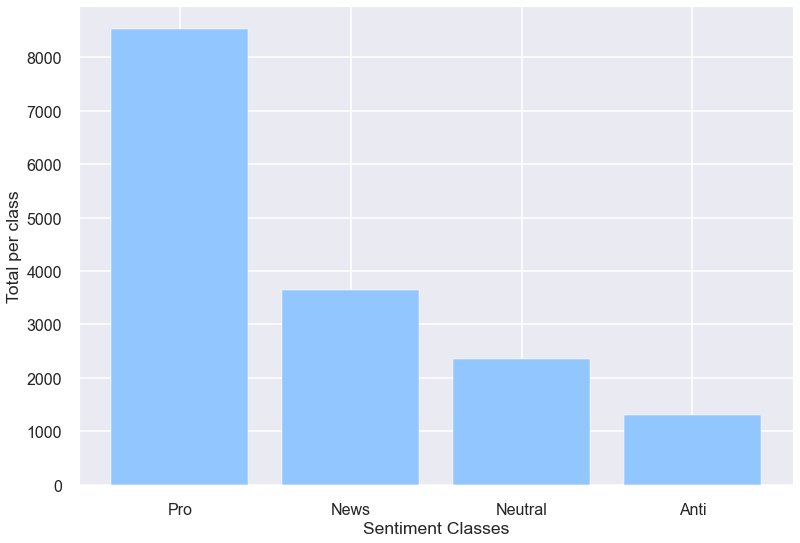

In [99]:
counts = df["sentiment"].value_counts()
plt.bar(range(len(counts)), counts)
plt.xticks([0, 1, 2, 3], ['Pro', 'News', 'Neutral', 'Anti'])


plt.ylabel("Total per class")
plt.xlabel("Sentiment Classes")
plt.show()

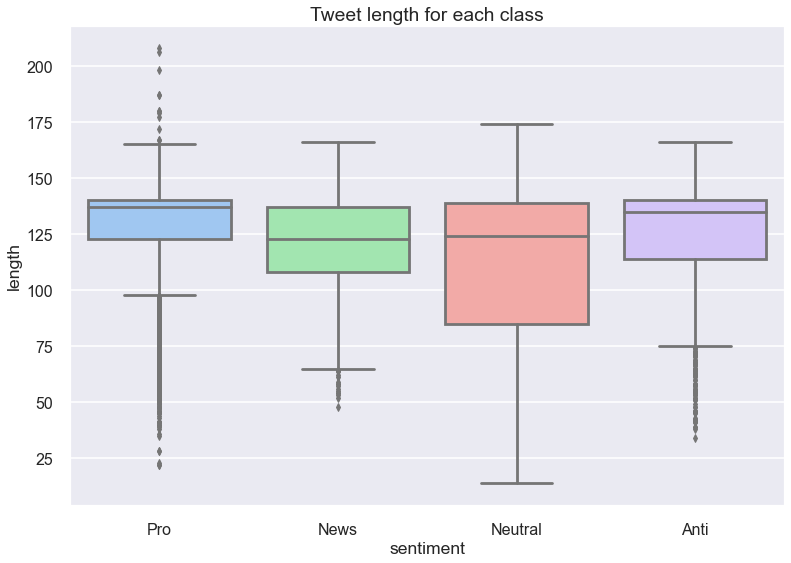

In [100]:
# Plot the distribution of the length tweets for each class using a box plot
sns.boxplot(x=df['sentiment'], y=df['length'], data=df)
plt.title('Tweet length for each class')
plt.show()

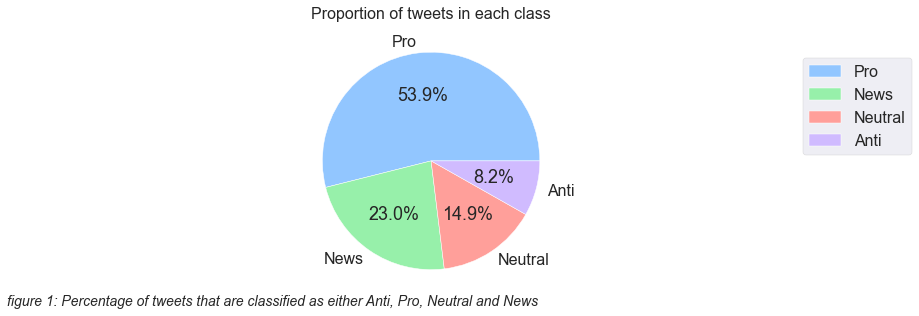

In [101]:
# Plot the proportion of tweets per class
plot1 = plt.figure(figsize=(15,5))
names = ['Pro','News','Neutral','Anti']
perc = df['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts()
perc.name = ''
perc.plot(kind='pie', labels=names, autopct='%1.1f%%')
plt.title('Proportion of tweets in each class',fontsize = 16)
plt.figtext(0.12, 0.1, 'figure 1: Percentage of tweets that are classified as either Anti, Pro, Neutral and News',
            horizontalalignment='left',fontsize = 14,style='italic')
plt.legend(df['sentiment'].replace({-1: 'Anti: Does not believe in man-made climate change',
                                          0:'Neutral: Neither believes nor refutes man-made climate change',
                                          1:'Pro:Believe in man-made climate change',
                                          2:'News: Factual News about climate change'}).value_counts().index,
           bbox_to_anchor=(2.3,0.7), loc="right")

plt.show()

The Pro climate change is the majority class accounting for about 54% of the data set and 46% being shared amongst the remaining classes. To deal with unbalanced data one can apply resampling to the classes, by adjusting the number of observations in the classes .Below is a  function to deal with the uneven distribution of class labels. The function will modify the number of observations for the classes we need to resample.

In [102]:
# Create resampling function
def resampling(df, class1, class2):
    """ A function takes in a dataframe, a class to be resampled, and a class 
        thats observations are to be matched with.

        Parameters
        ----------
        df:     Dataframe to be resampled.
        class1: Integer of the class that is to be resampled.
        class2: Integer of the class whose length is used to resample class1.

        Returns
        -------
        df_resampled:  Resampled dataframe.
    """
    
    df_class1= df[df.sentiment==class1]
    df_class2 = df[df.sentiment==class2]
    df_new= df[df.sentiment!=class1]
    resampled = resample(df_class1, replace=True, n_samples=len(df_class2.sentiment), random_state=50)
    df_resampled = pd.concat([resampled, df_new])    
    return df_resampled

In [103]:
# Create a resampled dataset from our clean dataset
df_resample = resampling(df_train, -1, 2)

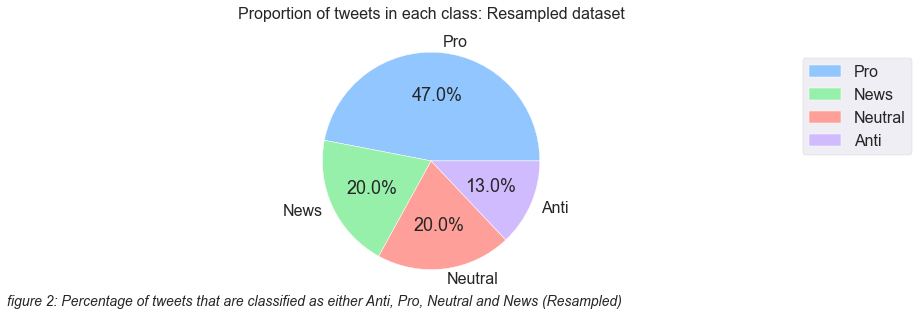

In [104]:
plot2 = plt.figure(figsize=(15,5))
names = ['Pro','News','Neutral','Anti']
perc = df_resample['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts()
perc.name = ''
perc.plot(kind='pie', labels=names, autopct='%1.1f%%')
plt.title('Proportion of tweets in each class: Resampled dataset',fontsize = 16)
plt.figtext(0.12, 0.1, 'figure 2: Percentage of tweets that are classified as either Anti, Pro, Neutral and News (Resampled)',
            horizontalalignment='left',fontsize = 14,style='italic')
plt.legend(df['sentiment'].replace({-1: 'Anti: Does not believe in man-made climate change',
                                          0:'Neutral: Neither believes nor refutes man-made climate change',
                                          1:'Pro:Believe in man-made climate change',
                                          2:'News: Factual News about climate change'}).value_counts().index,
           bbox_to_anchor=(2.3,0.7), loc="right")

plt.show()

# Splitting the data


In [58]:
# Split the dataset into train & validation for model training

# Seperate features and tagret variables
X = df_resample['message']
y = df_resample['sentiment']

# Split the train data to create validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

# Building Pipelines

In [59]:
# Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=5, 
                                              n_estimators=100))])

# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])

# K-NN Classifier
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=5, 
                                             metric='minkowski', 
                                             p=2))])

# Logistic Regression
lr = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression(C=1, 
                                         class_weight='balanced', 
                                         max_iter=1000))])
# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

# Model Training 

In [60]:
# Random forest 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

# Niave bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)

# K - nearest neighbors
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

# Linear regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

# Random forest classification

C:\Users\HP PAVILION\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average of the F-beta score of each class for the multiclass task.
C:\Users\HP PAVILION\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average of the F-beta score of each class for the multiclass task.
C:\Users\HP PAVILION\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  average of the F-beta score of each class for the multiclass t

              precision    recall  f1-score   support

          -1       1.00      0.02      0.03       725
           0       0.00      0.00      0.00       450
           1       0.48      1.00      0.65      1736
           2       0.00      0.00      0.00       722

    accuracy                           0.48      3633
   macro avg       0.37      0.25      0.17      3633
weighted avg       0.43      0.48      0.32      3633



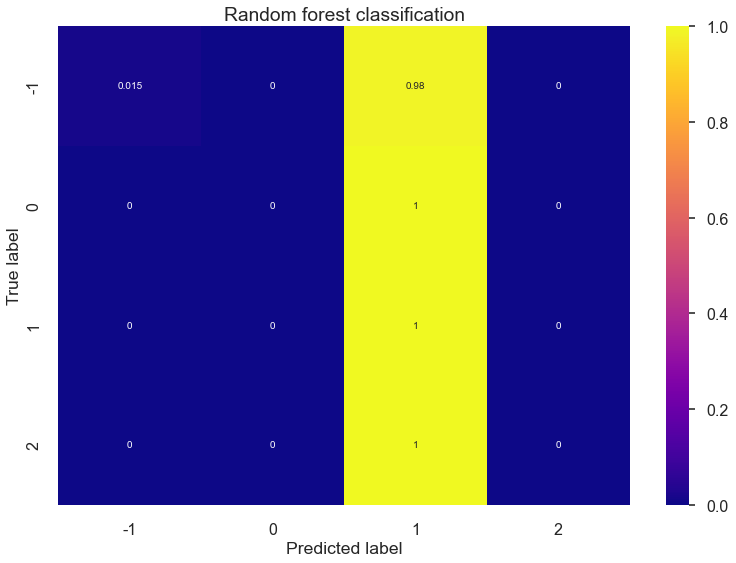

In [61]:
# Generate a classification Report for the random forest model
print(metrics.classification_report(y_valid, y_pred_rf))

# Generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_rf)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=rf.classes_, 
            yticklabels=rf.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Random forest classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Naive Bayes classification


              precision    recall  f1-score   support

          -1       0.96      0.58      0.72       725
           0       1.00      0.07      0.13       450
           1       0.61      0.99      0.75      1736
           2       0.89      0.41      0.56       722

    accuracy                           0.68      3633
   macro avg       0.87      0.51      0.54      3633
weighted avg       0.78      0.68      0.63      3633



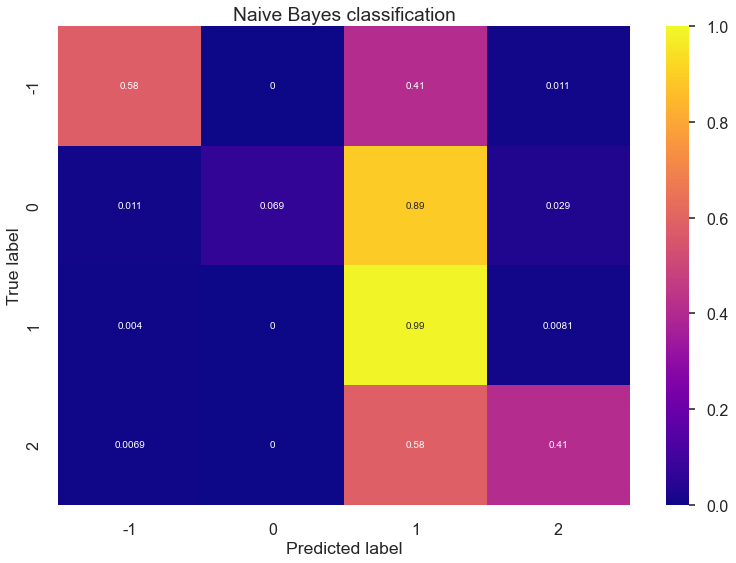

In [62]:
# Generate a classification Report for the Naive Bayes model
print(metrics.classification_report(y_valid, y_pred_nb))

# Generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_nb)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=nb.classes_, 
            yticklabels=nb.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Naive Bayes classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# K Nearest Neighbors classification

              precision    recall  f1-score   support

          -1       0.62      0.83      0.71       725
           0       0.50      0.37      0.43       450
           1       0.75      0.71      0.73      1736
           2       0.68      0.66      0.67       722

    accuracy                           0.68      3633
   macro avg       0.64      0.64      0.63      3633
weighted avg       0.68      0.68      0.68      3633



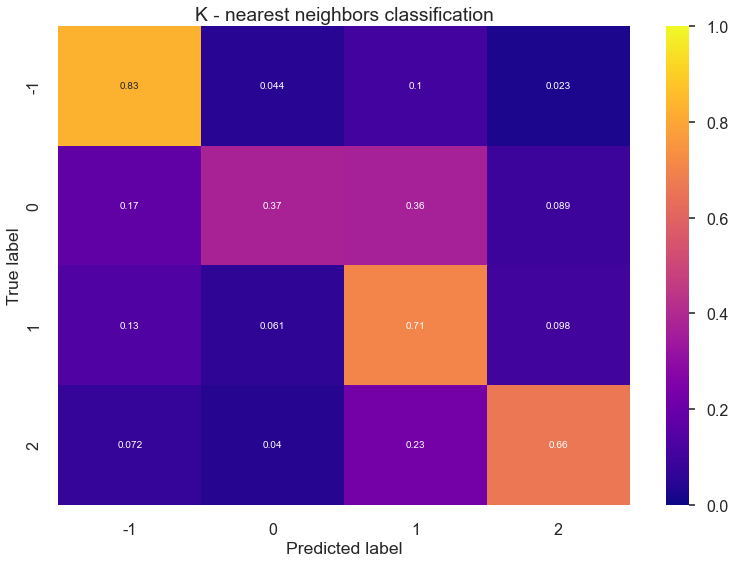

In [63]:
# Generate a classification Report for the K-nearest neighbors model
print(metrics.classification_report(y_valid, y_pred_knn))

# Generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_knn)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=knn.classes_, 
            yticklabels=knn.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('K - nearest neighbors classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Logistic Regression Classification

              precision    recall  f1-score   support

          -1       0.81      0.89      0.85       725
           0       0.48      0.56      0.52       450
           1       0.86      0.70      0.77      1736
           2       0.69      0.87      0.77       722

    accuracy                           0.75      3633
   macro avg       0.71      0.75      0.73      3633
weighted avg       0.77      0.75      0.75      3633



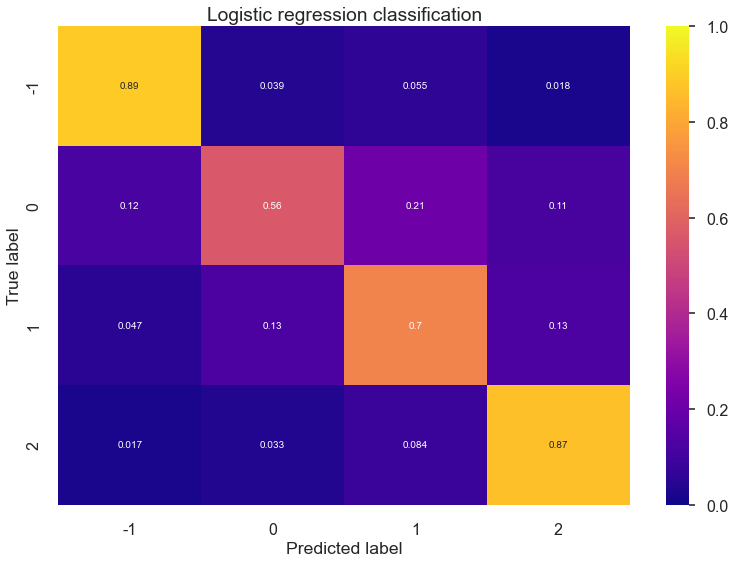

In [64]:
# Generate a classification Report for the model
print(metrics.classification_report(y_valid, y_pred_lr))

cm = confusion_matrix(y_valid, y_pred_lr)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=lr.classes_, 
            yticklabels=lr.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Logistic regression classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Linear SVC classification

              precision    recall  f1-score   support

          -1       0.87      0.94      0.90       725
           0       0.57      0.49      0.53       450
           1       0.84      0.80      0.82      1736
           2       0.75      0.85      0.80       722

    accuracy                           0.80      3633
   macro avg       0.76      0.77      0.76      3633
weighted avg       0.80      0.80      0.80      3633



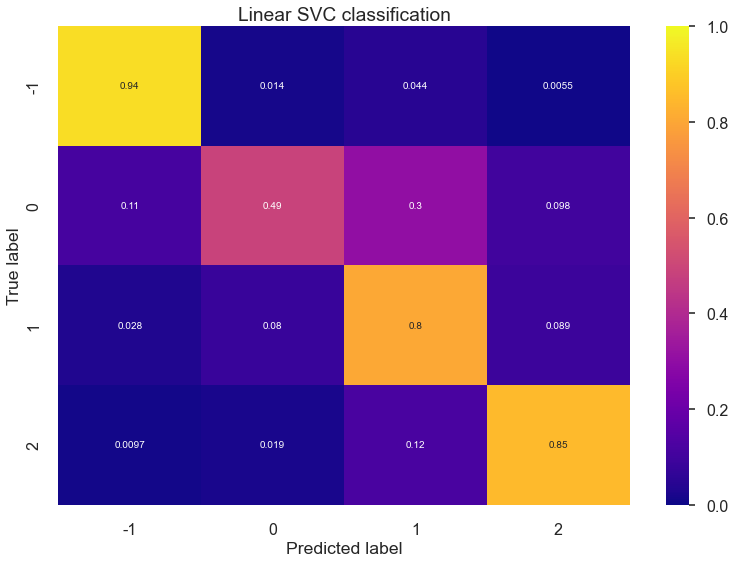

In [65]:
# Generate a classification Report for the linear SVC model
print(metrics.classification_report(y_valid, y_pred_lsvc))

# Generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_lsvc)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=lsvc.classes_, 
            yticklabels=lsvc.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Linear SVC classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Model Selection
The Linear SVC Classification model achieved the highest F1 score of 0.80. This will be our model of choice.

# Submission

In [67]:
test = pd.read_csv(r"C:\Users\HP PAVILION\Desktop\Python\ML\New folder (2)\Advanced_Classification_Predict-student_data-2780\test_with_no_labels.csv")
y_test = lsvc.predict(test['message'])
output = pd.DataFrame({'tweetid': test.tweetid,
                       'sentiment': y_test})
output.to_csv(r"C:\Users\HP PAVILION\Desktop\Python\ML\New folder (2)\Advanced_Classification_Predict-student_data-2780\submission.csv", index=False)
output

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892          0

[10546 rows x 2 columns]